In [1]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

In [2]:
BASE_PATH = '../input/coco-2017-dataset/coco2017'
inception_v3_mod = '../input/pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop (1).h5'

In [3]:
with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_PATH}/train2017/{x}'
)
captions = captions.sample(70000)
captions = captions.reset_index(drop=True)
captions.head()

,image,caption
0,../input/coco-2017-dataset/coco2017/train2017/...,"Green as an accent color in ribbons, vases of ..."
1,../input/coco-2017-dataset/coco2017/train2017/...,a woman sitting at a table with a plate of food
2,../input/coco-2017-dataset/coco2017/train2017/...,A hand holding a slice of pizza up to a small ...
3,../input/coco-2017-dataset/coco2017/train2017/...,A skateboarder performs a trick on his skate b...
4,../input/coco-2017-dataset/coco2017/train2017/...,A group of people walking towards an airplane


In [4]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [5]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,../input/coco-2017-dataset/coco2017/train2017/...,[start] green as an accent color in ribbons va...
1,../input/coco-2017-dataset/coco2017/train2017/...,[start] a woman sitting at a table with a plat...
2,../input/coco-2017-dataset/coco2017/train2017/...,[start] a hand holding a slice of pizza up to ...
3,../input/coco-2017-dataset/coco2017/train2017/...,[start] a skateboarder performs a trick on his...
4,../input/coco-2017-dataset/coco2017/train2017/...,[start] a group of people walking towards an a...


[start] there is a male skier riding down a snow hill [end]



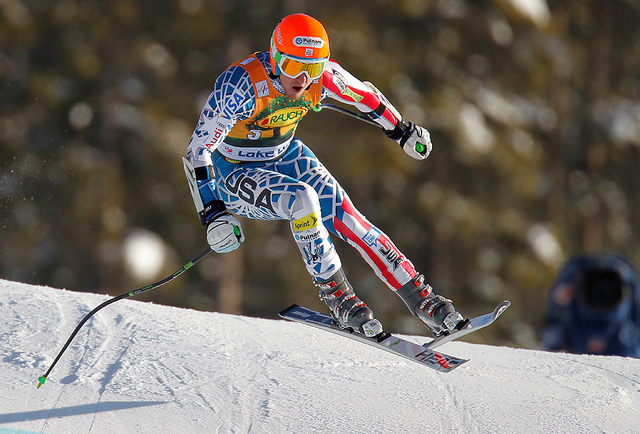

In [6]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

In [7]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 15000
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512
EPOCHS = 5

In [8]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

In [9]:
tokenizer.vocabulary_size()

11964

In [10]:
import pickle

pickle.dump(tokenizer.get_vocabulary(), open('vocab_coco.file', 'wb'))

In [11]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [12]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [13]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(55976, 55976, 14024, 14024)

In [14]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
inception_v3 = InceptionV3(
    include_top=False,
    weights=None  # We will load the weights manually
)
inception_v3.load_weights(inception_v3_mod)
def CNN_Encoder():
#     inception_v3 = tf.keras.applications.InceptionV3(
#         include_top=False,
#         weights='imagenet'
#     )

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [18]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [19]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [20]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
    

    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None
        
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [21]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [22]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [23]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [24]:
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/5


Cleanup called...
Cleanup called...


875/875 [==============================] - 788s 879ms/step - loss: 4.2479 - acc: 0.2375 - val_loss: 3.4839 - val_acc: 0.3852
Epoch 2/5


Cleanup called...
Cleanup called...


875/875 [==============================] - 610s 695ms/step - loss: 3.2975 - acc: 0.3886 - val_loss: 3.2130 - val_acc: 0.4134
Epoch 3/5


Cleanup called...
Cleanup called...


875/875 [==============================] - 610s 695ms/step - loss: 3.0512 - acc: 0.4155 - val_loss: 3.1027 - val_acc: 0.4240
Epoch 4/5


Cleanup called...
Cleanup called...


875/875 [==============================] - 616s 702ms/step - loss: 2.9060 - acc: 0.4310 - val_loss: 3.0704 - val_acc: 0.4273
Epoch 5/5


Cleanup called...
Cleanup called...


875/875 [==============================] - 612s 697ms/step - loss: 2.8016 - acc: 0.4394 - val_loss: 3.0420 - val_acc: 0.4321


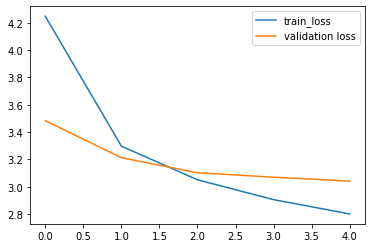

In [25]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [26]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)
    
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

Predicted Caption: a bathroom with a toilet and a toilet



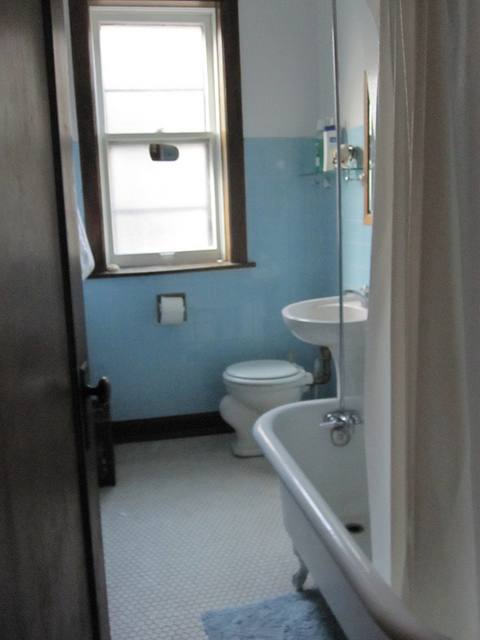

In [27]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

In [28]:
# img_url = "https://images.squarespace-cdn.com/content/v1/5e0e65adcd39ed279a0402fd/1627422658456-7QKPXTNQ34W2OMBTESCJ/1.jpg?format=2500w"

# im = Image.open(requests.get(img_url, stream=True).raw)
# im = im.convert('RGB')
# im.save('tmp.jpg')

# pred_caption = generate_caption('tmp.jpg', add_noise=False)
# print('Predicted Caption:', pred_caption)
# print()
# im

In [29]:
caption_model.save_weights('model.h5')